# Áp dụng mô hình học máy Naive Bayes cho phân loại béo phì

**Dữ liệu được sử dụng trong Notebook này đã qua tiền xử lý**

**Vì dữ liệu có cả liên tục và rời rạc nên người viết áp dụng chính 2 phương loại mô hình là Gaussian NB và Categorical NB**

## Phụ lục các hàm helper, import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/obesity_data_cleaned.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,1,0,...,0,0.000000,0.976473,1,0,0,0,1,0,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,2,0,...,0,1.000000,1.000000,0,1,0,0,0,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,1,0,...,0,0.866045,1.673584,0,0,0,0,1,0,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,1,0,...,0,1.467863,0.780199,1,0,0,0,1,0,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,1,0,...,0,1.967973,0.931721,1,0,0,0,1,0,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  int64  
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  int64  
 5   FAVC                            20758 non-null  int64  
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  int64  
 9   SMOKE                           20758 non-null  int64  
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  int64  
 12  FAF                             

### Train:test = [4:1,7:3,6:4]

In [ ]:
# @title
# Cell 1: Import thư viện

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 10


In [ ]:
# @title
# Cell 2: Đọc dữ liệu & chuẩn bị biến (updated)

DATA_PATH = "drive/MyDrive/Colab Notebooks/data/obesity_data_cleaned.csv"
TARGET_COL = "NObeyesdad"

# tham số train_size (mặc định 0.8 -> 80:20)
TRAIN_SIZE = 0.6

# random state cố định
RANDOM_STATE = 36

# set seed cho numpy (sklearn sẽ dùng RANDOM_STATE ở các chỗ random_state)
np.random.seed(RANDOM_STATE)

df = pd.read_csv(DATA_PATH)

# Encode nhãn mục tiêu về dạng số (0..n_classes-1)
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df[TARGET_COL])

# Đảm bảo target_names là list[str]
class_names = [str(c) for c in y_encoder.classes_]
n_classes = len(class_names)

# GaussianNB sử dụng các thuộc tính liên tục sau (sẽ được chuẩn hóa)
gaussian_features = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_gaussian = df[gaussian_features].copy()

# CategoricalNB sử dụng các biến categorical được cho
categorical_vars = {
    "Gender": {0: "Female", 1: "Male"},
    "family_history_with_overweight": {0: "No", 1: "Yes"},
    "FAVC": {0: "No", 1: "Yes"},
    "SMOKE": {0: "No", 1: "Yes"},
    "SCC": {0: "No", 1: "Yes"},
    "CAEC": {0: "no", 1: "Sometimes", 2: "Frequently", 3: "Always"},
    "CALC": {0: "no", 1: "Sometimes", 2: "Frequently", 3: "Always"},
    "MTRANS_Automobile": {0: "No", 1: "Yes"},
    "MTRANS_Bike": {0: "No", 1: "Yes"},
    "MTRANS_Motorbike": {0: "No", 1: "Yes"},
    "MTRANS_Public_Transportation": {0: "No", 1: "Yes"},
    "MTRANS_Walking": {0: "No", 1: "Yes"},
}

cat_feature_names = list(categorical_vars.keys())
X_categorical = df[cat_feature_names].copy()

# Giả định các cột categorical này đã là int 0..K-1 đúng như mapping trên.


In [ ]:
X_categorical.head()

,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,1,1,0,0,1,1,0,0,0,1,0
1,0,1,1,0,0,2,0,1,0,0,0,0
2,0,1,1,0,0,1,0,0,0,0,1,0
3,0,1,1,0,0,1,1,0,0,0,1,0
4,1,1,1,0,0,1,1,0,0,0,1,0


In [ ]:
# @title
# Cell 3 (revised): Hàm hỗ trợ vẽ và tính toán + mapping nhãn và colormap giống ảnh

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Mapping nhãn {0..6} → tên hiển thị (thứ tự đúng như hình)
LABEL_NAMES = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
    "Overweight_Level_I",
    "Overweight_Level_II",
]

def plot_gaussian_corr(df, gaussian_features, title="Correlation matrix - Gaussian features"):
    """
    Vẽ ma trận tương quan cho các biến gaussian_features (seaborn heatmap, tông nóng).
    """
    corr = df[gaussian_features].corr()
    plt.figure(figsize=(18, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",   # tông màu nóng
        square=True,
        cbar=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def _resolve_class_names(classes):
    """
    Trả về danh sách nhãn để vẽ:
    - Nếu classes None hoặc là list số {0..6} → dùng LABEL_NAMES
    - Nếu là list/array tên chuỗi → trả về nguyên trạng
    """
    if classes is None:
        return LABEL_NAMES
    # nếu là mảng số nguyên 0..6 thì map sang tên
    try:
        as_int = list(map(int, classes))
        if set(as_int) == set(range(len(LABEL_NAMES))):
            return LABEL_NAMES
    except Exception:
        pass
    # còn lại giữ nguyên (đã là tên chuỗi)
    return list(classes)


def plot_confusion_matrix(cm, classes=None, title="Confusion Matrix"):
    """
    Vẽ confusion matrix với colormap 'Blues' (dịu: xám/nhạt ở thấp → xanh đậm ở cao),
    giống phong cách trong ảnh người dùng cung cấp.
    """
    names = _resolve_class_names(classes)

    plt.figure(figsize=(9, 6))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",           # xanh dương dịu, tối dần theo giá trị
        cbar=True,
        linewidths=0.5,
        linecolor="white"
    )
    ax.set_title(title)
    ax.set_xlabel("Nhãn dự đoán")
    ax.set_ylabel("Nhãn thực tế")
    ax.set_xticks(np.arange(len(names)) + 0.5)
    ax.set_yticks(np.arange(len(names)) + 0.5)
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_yticklabels(names, rotation=0)
    plt.tight_layout()
    plt.show()


def compute_tn_tp_fp_fn(cm, classes=None):
    """
    Tính TN/TP/FP/FN theo one-vs-rest cho từng lớp từ confusion matrix đa lớp.
    Trả về DataFrame để hiển thị dạng bảng (index là tên lớp phù hợp).
    """
    total = cm.sum()
    n = cm.shape[0]

    rows = []
    for i in range(n):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FP + FN)
        rows.append({"TP": int(TP), "FP": int(FP), "FN": int(FN), "TN": int(TN)})

    names = _resolve_class_names(classes) if classes is not None else LABEL_NAMES
    df_stats = pd.DataFrame(rows, index=names)
    return df_stats


def plot_multiclass_roc_auc(y_true, y_proba, classes, title):
    """
    Vẽ ROC-AUC đa lớp (one-vs-rest), hiển thị macro-average AUC.
    """
    names = _resolve_class_names(classes)
    y_bin = label_binarize(y_true, classes=np.arange(len(names)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(names)
    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.3f})")
    for i in range(len(names)):
        plt.plot(fpr[i], tpr[i], lw=1, alpha=0.4)

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")  # sửa nhãn trục cho đúng
    plt.title(title)
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

    return macro_auc


def plot_cv_accuracy(cv_scores, title="10-fold CV Accuracy"):
    """
    Vẽ biểu đồ đường cho các giá trị CV accuracy và in accuracy trung bình ± std.
    """
    scores = np.asarray(cv_scores)
    mean_acc = scores.mean()
    std_acc = scores.std()

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(scores) + 1), scores, marker="o", linestyle="-")
    plt.axhline(mean_acc, linestyle="--", linewidth=1)
    plt.xticks(range(1, len(scores) + 1))
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print(f"{title}: {mean_acc:.4f} ± {std_acc:.4f}")
    return mean_acc, std_acc


In [ ]:
# @title
# Cell A: Helpers to log metrics and build the summary table

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

# Nơi lưu kết quả từ mọi cell
RESULTS = []

def _macro_auc_ovr(y_true, y_proba, n_classes):
    """
    Tính macro AUC (one-vs-rest) cho multi-class.
    y_proba: (n_samples, n_classes)
    """
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))
    # Một số lớp có thể vắng mặt ở y_true subset → cần try/except
    aucs = []
    for i in range(n_classes):
        yi = y_bin[:, i]
        # Bỏ qua lớp không xuất hiện ở y_true
        if yi.max() == yi.min():
            continue
        aucs.append(roc_auc_score(yi, y_proba[:, i]))
    return float(np.mean(aucs)) if aucs else np.nan

def add_result(split_label, method_label, y_true, y_pred, y_proba, n_classes, rounding=4):
    """
    Tính Accuracy, Precision/Recall/F1 (macro avg), AUC (macro OvR),
    rồi append vào RESULTS dưới dạng dict.
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    auc_macro = _macro_auc_ovr(y_true, y_proba, n_classes)

    RESULTS.append({
        "Kịch bản": split_label,          # ví dụ "80/20", "70/30", "60/40"
        "Phương pháp": method_label,      # ví dụ "Dữ liệu gốc", "PCA 4D", "LDA 4D"
        "Accuracy": round(acc, rounding),
        "Precision": round(prec, rounding),
        "Recall": round(rec, rounding),
        "F1-Score": round(f1, rounding),
        "AUC": round(auc_macro, rounding),
    })

def build_results_table(split_order=None, method_order=None,
                        sort_by=("Kịch bản", "Phương pháp"),
                        latex_path="summary_table.tex", csv_path="summary_table.csv"):
    """
    Trả về DataFrame đã sắp xếp và đồng thời lưu CSV/LaTeX để chèn vào báo cáo.
    """
    df = pd.DataFrame(RESULTS)

    # Sắp xếp theo thứ tự mong muốn (giống ảnh 2)
    if split_order is not None:
        df["Kịch bản"] = pd.Categorical(df["Kịch bản"], categories=split_order, ordered=True)
    if method_order is not None:
        df["Phương pháp"] = pd.Categorical(df["Phương pháp"], categories=method_order, ordered=True)

    df = df.sort_values(list(sort_by)).reset_index(drop=True)

    # Lưu CSV và LaTeX
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    latex_str = df.to_latex(index=False, float_format="%.4f")
    with open(latex_path, "w", encoding="utf-8") as f:
        f.write(latex_str)

    # Hiển thị
    display(df)
    print("\nLaTeX table saved to:", latex_path)
    print("CSV saved to:", csv_path)
    return df, latex_str


## 1. GaussianNB

### GaussianNB - Original

GaussianNB - Original Features
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1009
           1       0.60      0.37      0.46      1233
           2       0.58      0.49      0.53      1164
           3       0.87      0.84      0.86      1299
           4       0.66      1.00      0.80      1619
           5       0.46      0.35      0.40       971
           6       0.49      0.52      0.50      1009

    accuracy                           0.65      8304
   macro avg       0.63      0.62      0.62      8304
weighted avg       0.64      0.65      0.63      8304



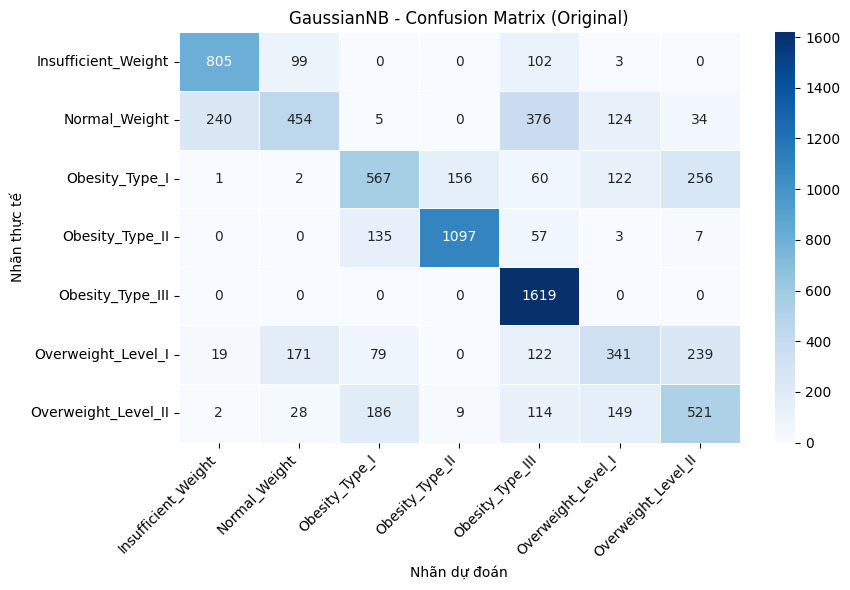

,TP,FP,FN,TN
Insufficient_Weight,805,262,204,7033
Normal_Weight,454,300,779,6771
Obesity_Type_I,567,405,597,6735
Obesity_Type_II,1097,165,202,6840
Obesity_Type_III,1619,831,0,5854
Overweight_Level_I,341,401,630,6932
Overweight_Level_II,521,536,488,6759


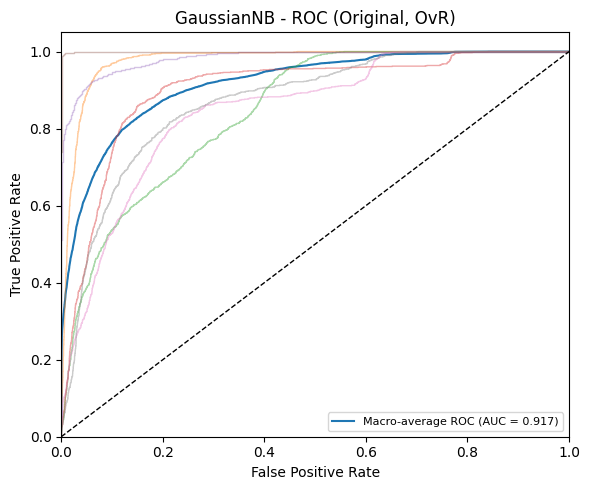

Macro-average AUC (Original): 0.9173


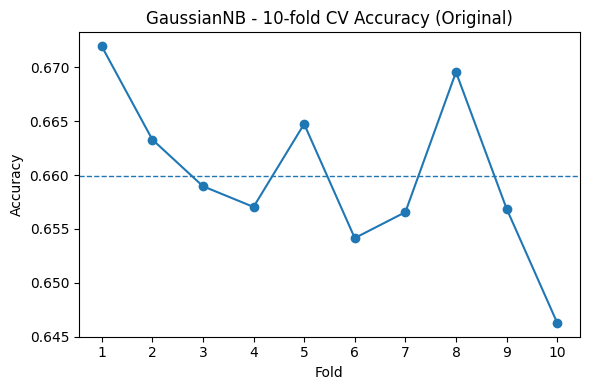

GaussianNB - 10-fold CV Accuracy (Original): 0.6599 ± 0.0072


In [ ]:
# Cell 4 (renamed vars): GaussianNB - Original

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

Xg_train_og, Xg_test_og, yg_train_og, yg_test_og = train_test_split(
    X_gaussian, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_og = StandardScaler()
Xg_train_og_s = scaler_og.fit_transform(Xg_train_og)
Xg_test_og_s  = scaler_og.transform(Xg_test_og)

gnb_og = GaussianNB()
gnb_og.fit(Xg_train_og_s, yg_train_og)

yg_pred_og  = gnb_og.predict(Xg_test_og_s)
yg_proba_og = gnb_og.predict_proba(Xg_test_og_s)

print("GaussianNB - Original Features")
print(classification_report(yg_test_og, yg_pred_og, target_names=class_names))

cm_og = confusion_matrix(yg_test_og, yg_pred_og)
plot_confusion_matrix(cm_og, class_names, "GaussianNB - Confusion Matrix (Original)")
stats_og_df = compute_tn_tp_fp_fn(cm_og, classes=class_names); display(stats_og_df)

auc_macro_og = plot_multiclass_roc_auc(yg_test_og, yg_proba_og, class_names,
                                       "GaussianNB - ROC (Original, OvR)")
print(f"Macro-average AUC (Original): {auc_macro_og:.4f}")

cv_og = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_og = Pipeline([("scaler", StandardScaler()), ("gnb", GaussianNB())])
cv_scores_og = cross_val_score(pipe_og, X_gaussian, y, cv=cv_og, scoring="accuracy")
plot_cv_accuracy(cv_scores_og, title="GaussianNB - 10-fold CV Accuracy (Original)")

# log
add_result(split_label, "Dữ liệu gốc", yg_test_og, yg_pred_og, yg_proba_og, n_classes)


### 1.2 GaussianNB - No Weight

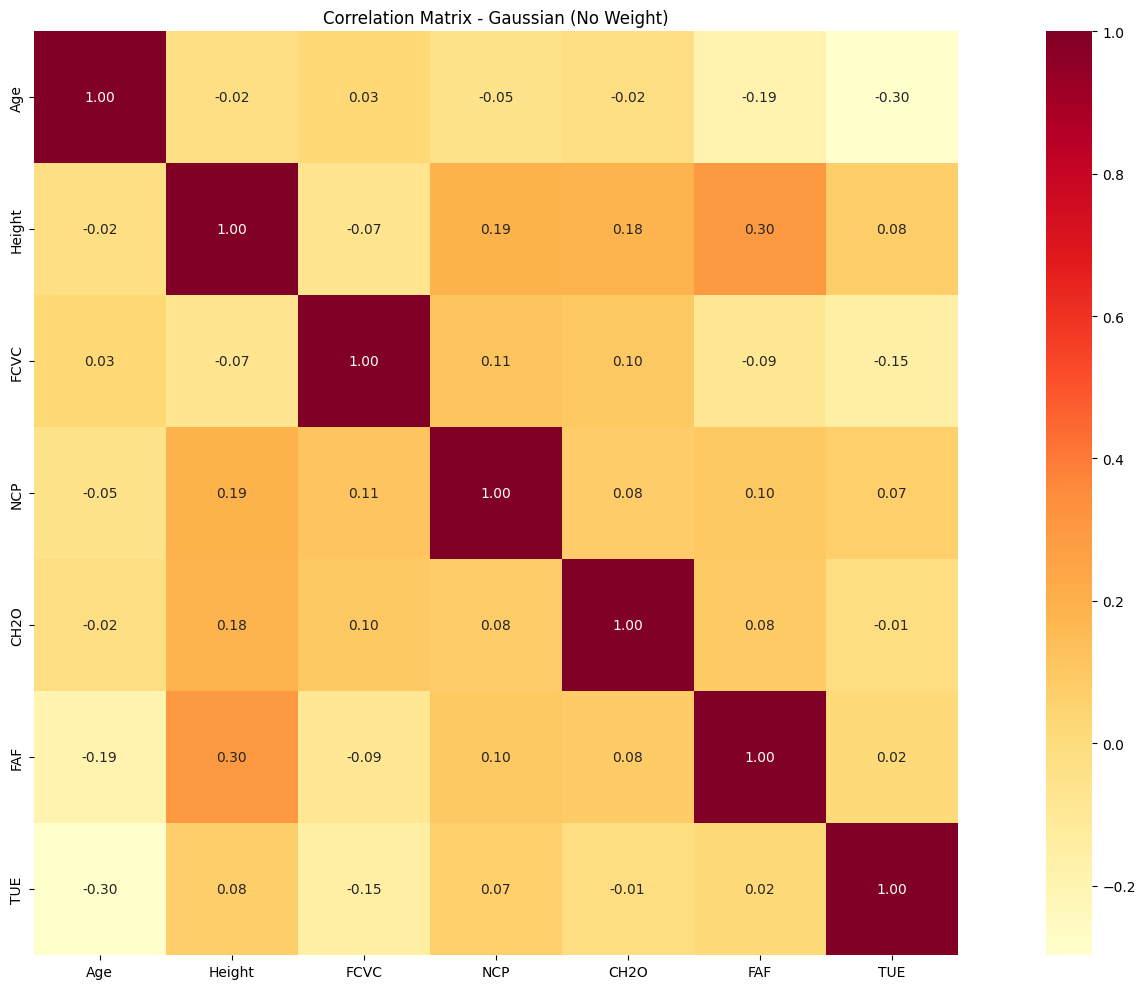

GaussianNB - No Weight
              precision    recall  f1-score   support

           0       0.47      0.57      0.52      1009
           1       0.30      0.30      0.30      1233
           2       0.47      0.40      0.44      1164
           3       0.68      0.78      0.72      1299
           4       0.61      1.00      0.76      1619
           5       0.35      0.17      0.23       971
           6       0.36      0.11      0.17      1009

    accuracy                           0.52      8304
   macro avg       0.46      0.47      0.45      8304
weighted avg       0.48      0.52      0.48      8304



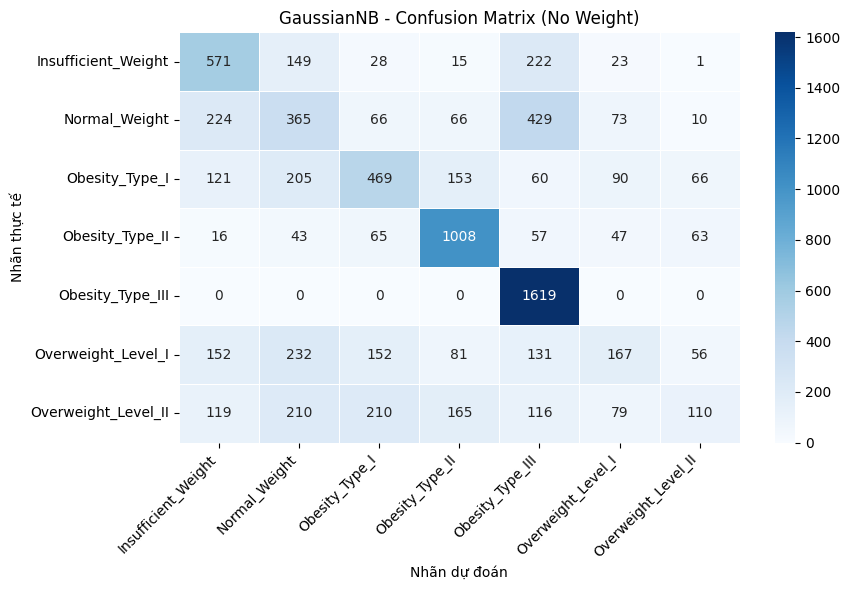

,TP,FP,FN,TN
Insufficient_Weight,571,632,438,6663
Normal_Weight,365,839,868,6232
Obesity_Type_I,469,521,695,6619
Obesity_Type_II,1008,480,291,6525
Obesity_Type_III,1619,1015,0,5670
Overweight_Level_I,167,312,804,7021
Overweight_Level_II,110,196,899,7099


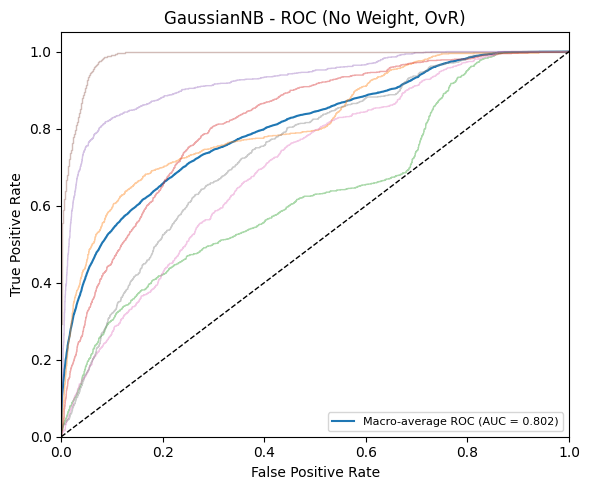

Macro-average AUC (No Weight): 0.8023


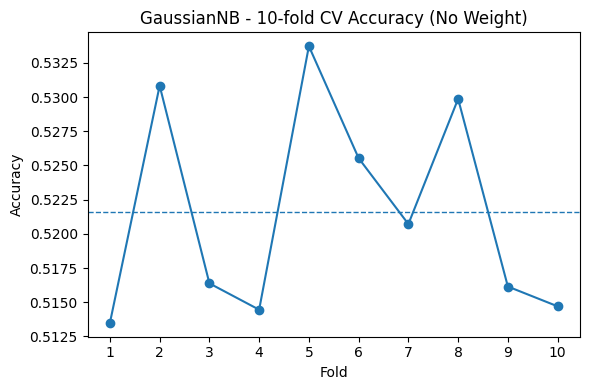

GaussianNB - 10-fold CV Accuracy (No Weight): 0.5216 ± 0.0073


In [ ]:
# Cell 4.1 (renamed vars): GaussianNB - No Weight

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

gaussian_features_no_w = [f for f in gaussian_features if f != "Weight"]
X_gaussian_no_w = df[gaussian_features_no_w].copy()

plot_gaussian_corr(df, gaussian_features_no_w, "Correlation Matrix - Gaussian (No Weight)")

Xg_train_now, Xg_test_now, yg_train_now, yg_test_now = train_test_split(
    X_gaussian_no_w, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_now = StandardScaler()
Xg_train_now_s = scaler_now.fit_transform(Xg_train_now)
Xg_test_now_s  = scaler_now.transform(Xg_test_now)

gnb_now = GaussianNB()
gnb_now.fit(Xg_train_now_s, yg_train_now)

yg_pred_now  = gnb_now.predict(Xg_test_now_s)
yg_proba_now = gnb_now.predict_proba(Xg_test_now_s)

print("GaussianNB - No Weight")
print(classification_report(yg_test_now, yg_pred_now, target_names=class_names))

cm_now = confusion_matrix(yg_test_now, yg_pred_now)
plot_confusion_matrix(cm_now, class_names, "GaussianNB - Confusion Matrix (No Weight)")
stats_now_df = compute_tn_tp_fp_fn(cm_now, classes=class_names); display(stats_now_df)

auc_macro_now = plot_multiclass_roc_auc(yg_test_now, yg_proba_now, class_names,
                                        "GaussianNB - ROC (No Weight, OvR)")
print(f"Macro-average AUC (No Weight): {auc_macro_now:.4f}")

cv_now = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_now = Pipeline([("scaler", StandardScaler()), ("gnb", GaussianNB())])
cv_scores_now = cross_val_score(pipe_now, X_gaussian_no_w, y, cv=cv_now, scoring="accuracy")
plot_cv_accuracy(cv_scores_now, title="GaussianNB - 10-fold CV Accuracy (No Weight)")

# log
add_result(split_label, "No Weight", yg_test_now, yg_pred_now, yg_proba_now, n_classes)


### 1.3 GaussianNB - Feature Engineering

GaussianNB - Feature Engineered Features
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1009
           1       0.83      0.69      0.75      1233
           2       0.70      0.71      0.71      1164
           3       0.90      0.83      0.87      1299
           4       0.88      1.00      0.94      1619
           5       0.60      0.60      0.60       971
           6       0.62      0.57      0.59      1009

    accuracy                           0.78      8304
   macro avg       0.77      0.77      0.76      8304
weighted avg       0.78      0.78      0.78      8304



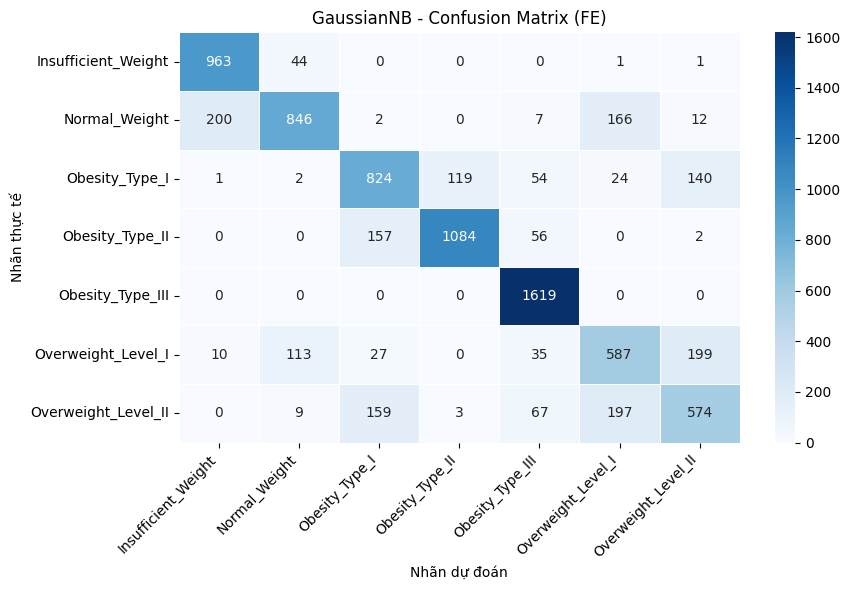

,TP,FP,FN,TN
Insufficient_Weight,963,211,46,7084
Normal_Weight,846,168,387,6903
Obesity_Type_I,824,345,340,6795
Obesity_Type_II,1084,122,215,6883
Obesity_Type_III,1619,219,0,6466
Overweight_Level_I,587,388,384,6945
Overweight_Level_II,574,354,435,6941


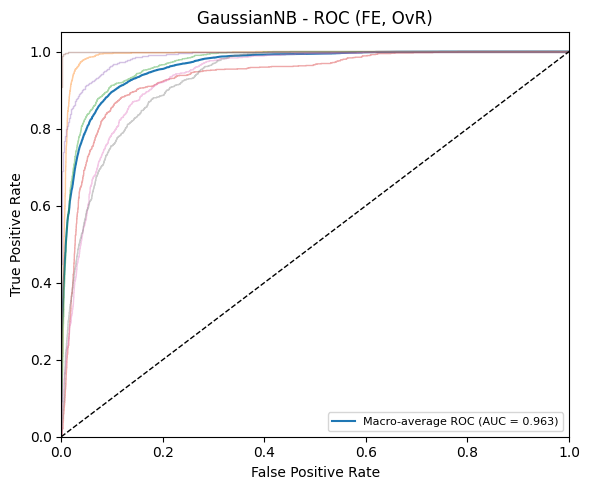

Macro-average AUC (FE): 0.9626


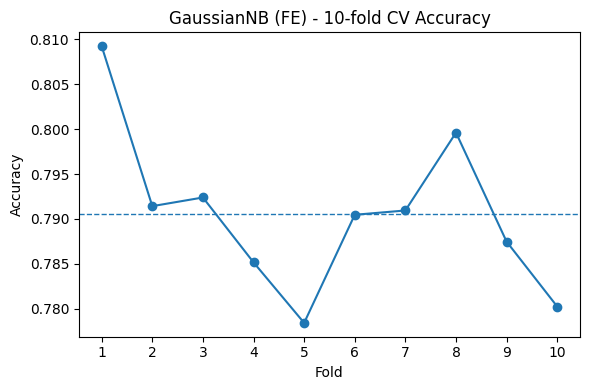

GaussianNB (FE) - 10-fold CV Accuracy: 0.7905 ± 0.0085


In [ ]:
# Cell 6 (renamed vars): GaussianNB - Feature Engineering

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

Xfe_train, Xfe_test, yfe_train, yfe_test = train_test_split(
    X_gaussian_fe, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_fe = StandardScaler()
Xfe_train_s = scaler_fe.fit_transform(Xfe_train)
Xfe_test_s  = scaler_fe.transform(Xfe_test)

gnb_fe_model = GaussianNB()
gnb_fe_model.fit(Xfe_train_s, yfe_train)

yfe_pred  = gnb_fe_model.predict(Xfe_test_s)
yfe_proba = gnb_fe_model.predict_proba(Xfe_test_s)

print("GaussianNB - Feature Engineered Features")
print(classification_report(yfe_test, yfe_pred, target_names=class_names))

cm_fe = confusion_matrix(yfe_test, yfe_pred)
plot_confusion_matrix(cm_fe, class_names, "GaussianNB - Confusion Matrix (FE)")
stats_fe_df = compute_tn_tp_fp_fn(cm_fe, classes=class_names); display(stats_fe_df)

auc_macro_fe = plot_multiclass_roc_auc(yfe_test, yfe_proba, class_names,
                                       "GaussianNB - ROC (FE, OvR)")
print(f"Macro-average AUC (FE): {auc_macro_fe:.4f}")

cv_fe = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_fe_cv = Pipeline([("scaler", StandardScaler()), ("gnb", GaussianNB())])
cv_scores_fe = cross_val_score(pipe_fe_cv, X_gaussian_fe, y, cv=cv_fe, scoring="accuracy")
plot_cv_accuracy(cv_scores_fe, title="GaussianNB (FE) - 10-fold CV Accuracy")

# log
add_result(split_label, "FE", yfe_test, yfe_pred, yfe_proba, n_classes)


### 1.4 PCA(4) + GaussianNB on FE

GaussianNB + PCA(4) - FE
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1009
           1       0.39      0.59      0.47      1233
           2       0.48      0.48      0.48      1164
           3       0.54      0.58      0.56      1299
           4       0.78      0.87      0.82      1619
           5       0.34      0.22      0.27       971
           6       0.35      0.23      0.28      1009

    accuracy                           0.53      8304
   macro avg       0.50      0.50      0.49      8304
weighted avg       0.52      0.53      0.52      8304



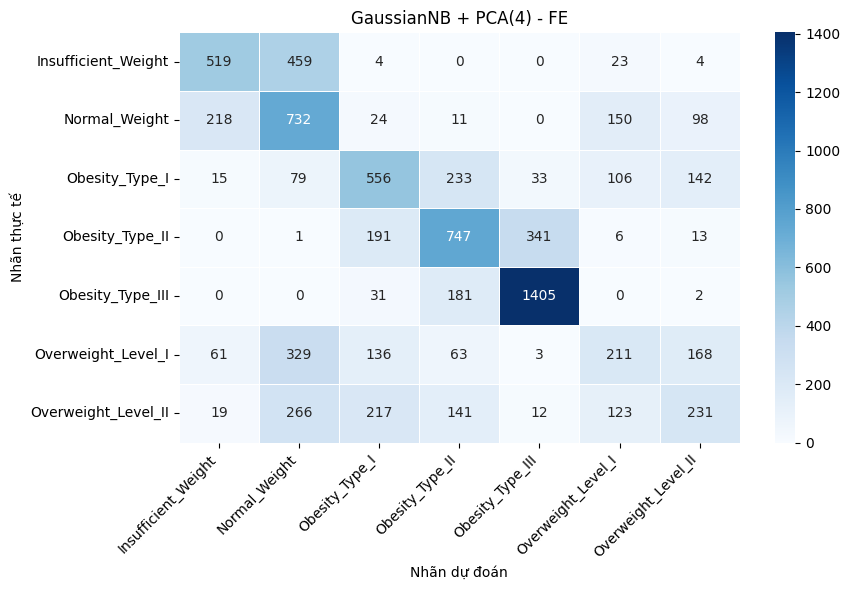

,TP,FP,FN,TN
Insufficient_Weight,519,313,490,6982
Normal_Weight,732,1134,501,5937
Obesity_Type_I,556,603,608,6537
Obesity_Type_II,747,629,552,6376
Obesity_Type_III,1405,389,214,6296
Overweight_Level_I,211,408,760,6925
Overweight_Level_II,231,427,778,6868


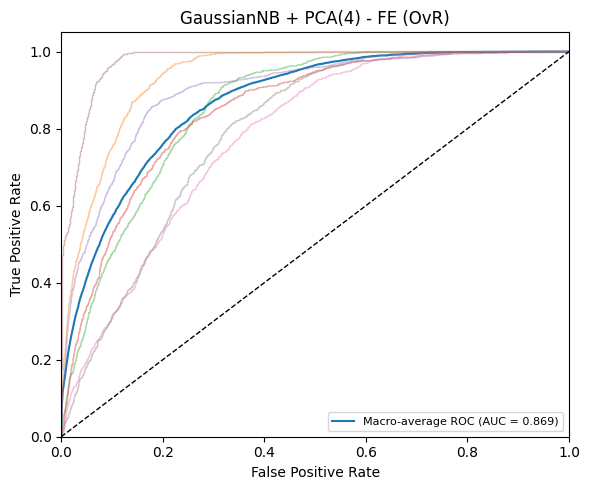

Macro-average AUC (PCA FE): 0.8694


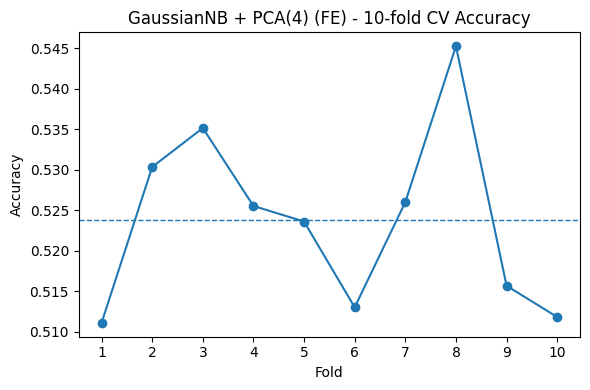

GaussianNB + PCA(4) (FE) - 10-fold CV Accuracy: 0.5237 ± 0.0106


In [ ]:
# Cell 7 (renamed vars): PCA(4) + GaussianNB on FE

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

Xp_train_fe, Xp_test_fe, yp_train_fe, yp_test_fe = train_test_split(
    X_gaussian_fe, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_pca_fe = StandardScaler()
pca_fe = PCA(n_components=4, random_state=RANDOM_STATE)

Xp_train_fe_s = scaler_pca_fe.fit_transform(Xp_train_fe)
Xp_test_fe_s  = scaler_pca_fe.transform(Xp_test_fe)
Xp_train_fe_p = pca_fe.fit_transform(Xp_train_fe_s)
Xp_test_fe_p  = pca_fe.transform(Xp_test_fe_s)

gnb_pca_fe = GaussianNB()
gnb_pca_fe.fit(Xp_train_fe_p, yp_train_fe)

yp_pred_fe  = gnb_pca_fe.predict(Xp_test_fe_p)
yp_proba_fe = gnb_pca_fe.predict_proba(Xp_test_fe_p)

print("GaussianNB + PCA(4) - FE")
print(classification_report(yp_test_fe, yp_pred_fe, target_names=class_names))

cm_pca_fe = confusion_matrix(yp_test_fe, yp_pred_fe)
plot_confusion_matrix(cm_pca_fe, class_names, "GaussianNB + PCA(4) - FE")
stats_pca_fe_df = compute_tn_tp_fp_fn(cm_pca_fe, classes=class_names); display(stats_pca_fe_df)

auc_macro_pca_fe = plot_multiclass_roc_auc(yp_test_fe, yp_proba_fe, class_names,
                                           "GaussianNB + PCA(4) - FE (OvR)")
print(f"Macro-average AUC (PCA FE): {auc_macro_pca_fe:.4f}")

cv_pca_fe = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_pca_fe = Pipeline([("scaler", StandardScaler()),
                        ("pca", PCA(n_components=4, random_state=RANDOM_STATE)),
                        ("gnb", GaussianNB())])
cv_scores_pca_fe = cross_val_score(pipe_pca_fe, X_gaussian_fe, y, cv=cv_pca_fe, scoring="accuracy")
plot_cv_accuracy(cv_scores_pca_fe, title="GaussianNB + PCA(4) (FE) - 10-fold CV Accuracy")

# log
add_result(split_label, "PCA 4D (FE)", yp_test_fe, yp_pred_fe, yp_proba_fe, n_classes)


### 1.5 LDA(4) + GaussianNB on FE

GaussianNB + LDA(4) - FE
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1009
           1       0.84      0.70      0.76      1233
           2       0.79      0.77      0.78      1164
           3       0.89      0.91      0.90      1299
           4       0.96      0.97      0.96      1619
           5       0.61      0.69      0.64       971
           6       0.65      0.60      0.62      1009

    accuracy                           0.81      8304
   macro avg       0.80      0.80      0.79      8304
weighted avg       0.81      0.81      0.81      8304



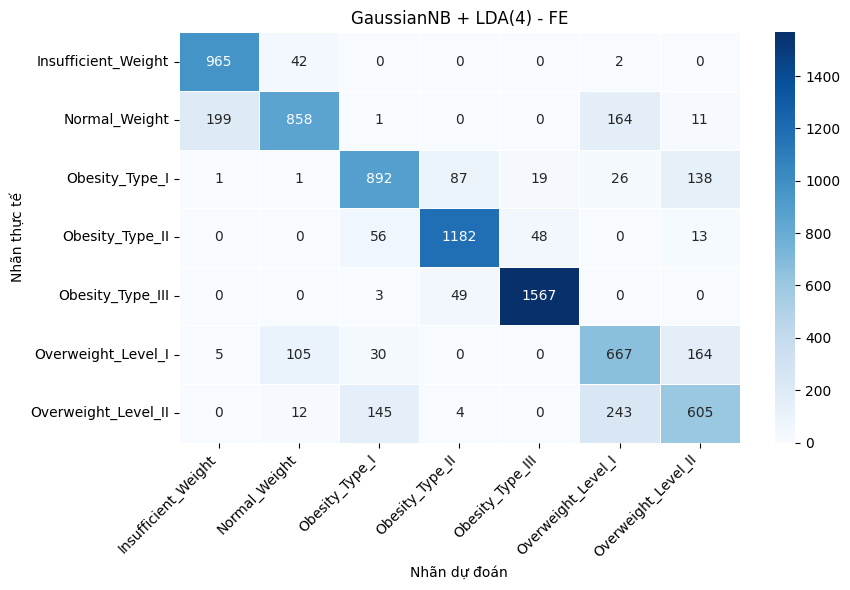

,TP,FP,FN,TN
Insufficient_Weight,965,205,44,7090
Normal_Weight,858,160,375,6911
Obesity_Type_I,892,235,272,6905
Obesity_Type_II,1182,140,117,6865
Obesity_Type_III,1567,67,52,6618
Overweight_Level_I,667,435,304,6898
Overweight_Level_II,605,326,404,6969


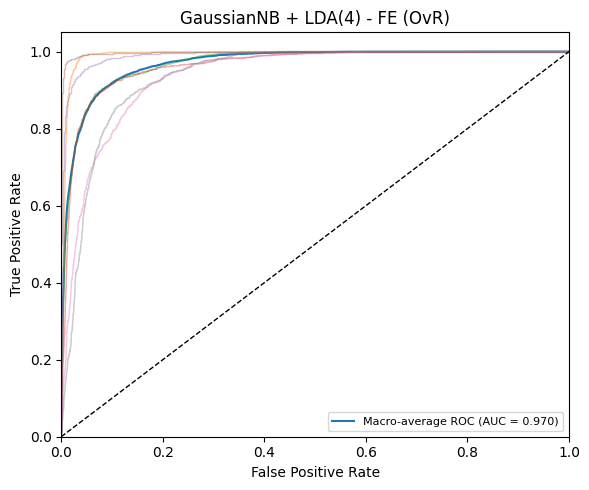

Macro-average AUC (LDA FE): 0.9698


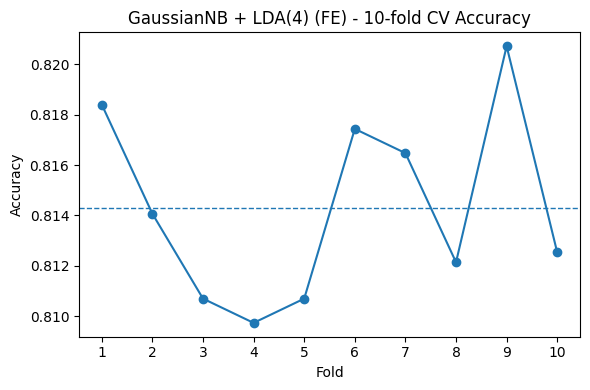

GaussianNB + LDA(4) (FE) - 10-fold CV Accuracy: 0.8143 ± 0.0036


In [ ]:
# Cell 8 (renamed vars): LDA(4) + GaussianNB on FE

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

Xl_train_fe, Xl_test_fe, yl_train_fe, yl_test_fe = train_test_split(
    X_gaussian_fe, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_lda_fe = StandardScaler()
lda_fe = LDA(n_components=4)

Xl_train_fe_s = scaler_lda_fe.fit_transform(Xl_train_fe)
Xl_test_fe_s  = scaler_lda_fe.transform(Xl_test_fe)
Xl_train_fe_l = lda_fe.fit_transform(Xl_train_fe_s, yl_train_fe)
Xl_test_fe_l  = lda_fe.transform(Xl_test_fe_s)

gnb_lda_fe = GaussianNB()
gnb_lda_fe.fit(Xl_train_fe_l, yl_train_fe)

yl_pred_fe  = gnb_lda_fe.predict(Xl_test_fe_l)
yl_proba_fe = gnb_lda_fe.predict_proba(Xl_test_fe_l)

print("GaussianNB + LDA(4) - FE")
print(classification_report(yl_test_fe, yl_pred_fe, target_names=class_names))

cm_lda_fe = confusion_matrix(yl_test_fe, yl_pred_fe)
plot_confusion_matrix(cm_lda_fe, class_names, "GaussianNB + LDA(4) - FE")
stats_lda_fe_df = compute_tn_tp_fp_fn(cm_lda_fe, classes=class_names); display(stats_lda_fe_df)

auc_macro_lda_fe = plot_multiclass_roc_auc(yl_test_fe, yl_proba_fe, class_names,
                                           "GaussianNB + LDA(4) - FE (OvR)")
print(f"Macro-average AUC (LDA FE): {auc_macro_lda_fe:.4f}")

cv_lda_fe = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_lda_fe = Pipeline([("scaler", StandardScaler()),
                        ("lda", LDA(n_components=4)),
                        ("gnb", GaussianNB())])
cv_scores_lda_fe = cross_val_score(pipe_lda_fe, X_gaussian_fe, y, cv=cv_lda_fe, scoring="accuracy")
plot_cv_accuracy(cv_scores_lda_fe, title="GaussianNB + LDA(4) (FE) - 10-fold CV Accuracy")

# log
add_result(split_label, "LDA 4D (FE)", yl_test_fe, yl_pred_fe, yl_proba_fe, n_classes)


### 1.6 LDA(4) + GaussianNB on Original dataset

GaussianNB + LDA(4) - Original
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1009
           1       0.81      0.73      0.77      1233
           2       0.81      0.75      0.78      1164
           3       0.90      0.93      0.92      1299
           4       0.98      0.98      0.98      1619
           5       0.61      0.68      0.64       971
           6       0.63      0.61      0.62      1009

    accuracy                           0.81      8304
   macro avg       0.80      0.80      0.80      8304
weighted avg       0.82      0.81      0.81      8304



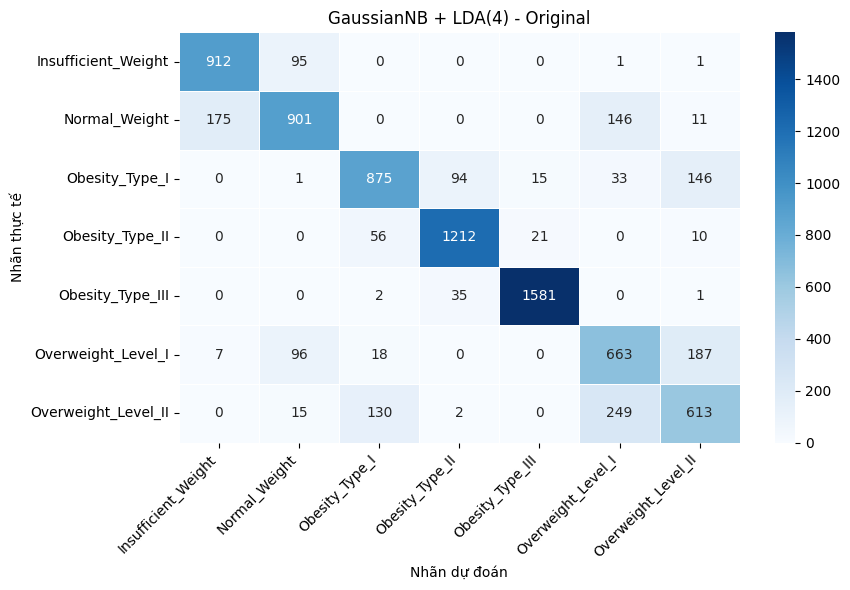

,TP,FP,FN,TN
Insufficient_Weight,912,182,97,7113
Normal_Weight,901,207,332,6864
Obesity_Type_I,875,206,289,6934
Obesity_Type_II,1212,131,87,6874
Obesity_Type_III,1581,36,38,6649
Overweight_Level_I,663,429,308,6904
Overweight_Level_II,613,356,396,6939


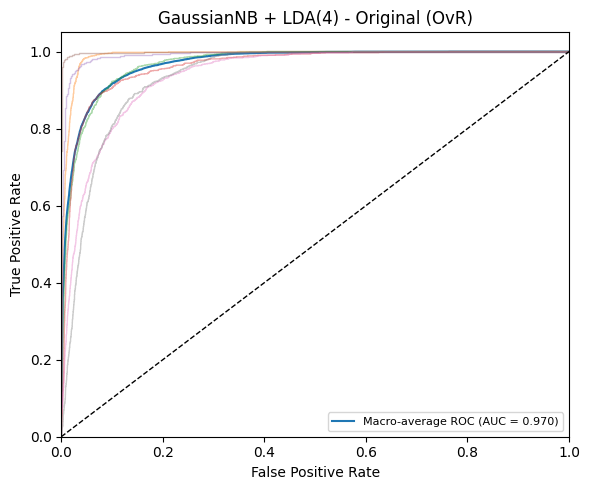

Macro-average AUC (LDA Original): 0.9697


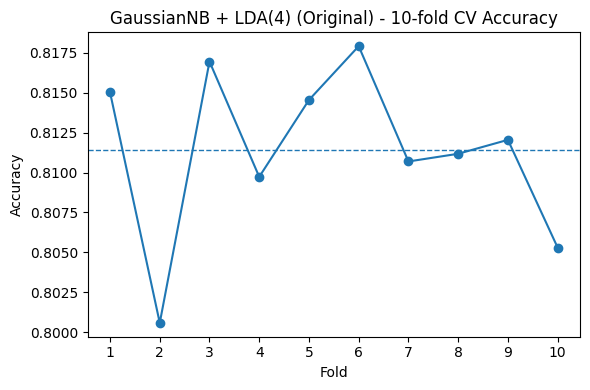

GaussianNB + LDA(4) (Original) - 10-fold CV Accuracy: 0.8114 ± 0.0050


In [ ]:
# Cell 5.2 (renamed vars): LDA(4) + GaussianNB on Original

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

Xl_train_og, Xl_test_og, yl_train_og, yl_test_og = train_test_split(
    X_gaussian, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler_lda_og = StandardScaler()
lda_og = LDA(n_components=4)

Xl_train_og_s = scaler_lda_og.fit_transform(Xl_train_og)
Xl_test_og_s  = scaler_lda_og.transform(Xl_test_og)
Xl_train_og_l = lda_og.fit_transform(Xl_train_og_s, yl_train_og)
Xl_test_og_l  = lda_og.transform(Xl_test_og_s)

gnb_lda_og = GaussianNB()
gnb_lda_og.fit(Xl_train_og_l, yl_train_og)

yl_pred_og  = gnb_lda_og.predict(Xl_test_og_l)
yl_proba_og = gnb_lda_og.predict_proba(Xl_test_og_l)

print("GaussianNB + LDA(4) - Original")
print(classification_report(yl_test_og, yl_pred_og, target_names=class_names))

cm_lda_og = confusion_matrix(yl_test_og, yl_pred_og)
plot_confusion_matrix(cm_lda_og, class_names, "GaussianNB + LDA(4) - Original")
stats_lda_og_df = compute_tn_tp_fp_fn(cm_lda_og, classes=class_names); display(stats_lda_og_df)

auc_macro_lda_og = plot_multiclass_roc_auc(yl_test_og, yl_proba_og, class_names,
                                           "GaussianNB + LDA(4) - Original (OvR)")
print(f"Macro-average AUC (LDA Original): {auc_macro_lda_og:.4f}")

cv_lda_og = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
pipe_lda_og = Pipeline([("scaler", StandardScaler()),
                        ("lda", LDA(n_components=4)),
                        ("gnb", GaussianNB())])
cv_scores_lda_og = cross_val_score(pipe_lda_og, X_gaussian, y, cv=cv_lda_og, scoring="accuracy")
plot_cv_accuracy(cv_scores_lda_og, title="GaussianNB + LDA(4) (Original) - 10-fold CV Accuracy")

# log
add_result(split_label, "LDA 4D (Original)", yl_test_og, yl_pred_og, yl_proba_og, n_classes)


## 2.CategoricalNB

CategoricalNB - Categorical features only
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      1009
           1       0.47      0.30      0.37      1233
           2       0.45      0.54      0.49      1164
           3       0.51      0.83      0.63      1299
           4       0.80      1.00      0.89      1619
           5       0.58      0.18      0.28       971
           6       0.44      0.23      0.30      1009

    accuracy                           0.57      8304
   macro avg       0.54      0.53      0.50      8304
weighted avg       0.55      0.57      0.53      8304



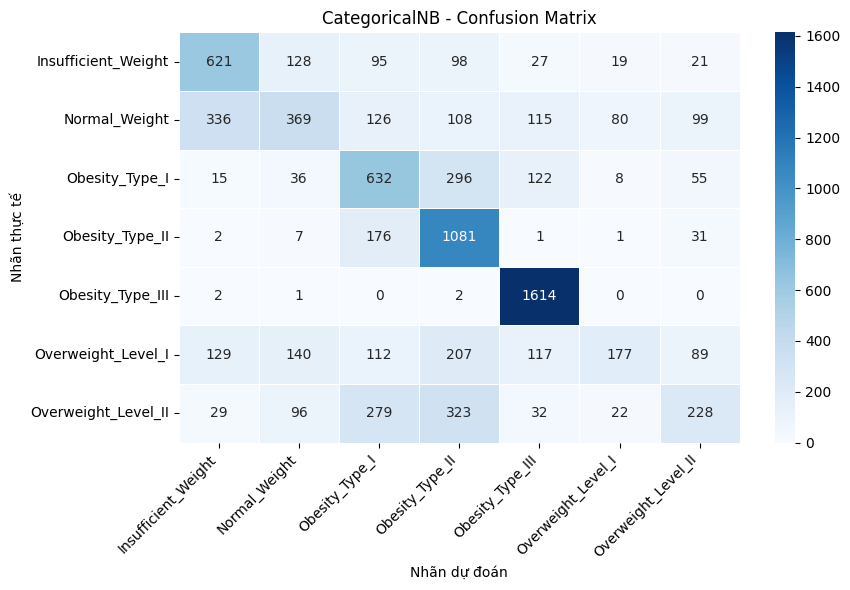

,TP,FP,FN,TN
Insufficient_Weight,621,513,388,6782
Normal_Weight,369,408,864,6663
Obesity_Type_I,632,788,532,6352
Obesity_Type_II,1081,1034,218,5971
Obesity_Type_III,1614,414,5,6271
Overweight_Level_I,177,130,794,7203
Overweight_Level_II,228,295,781,7000


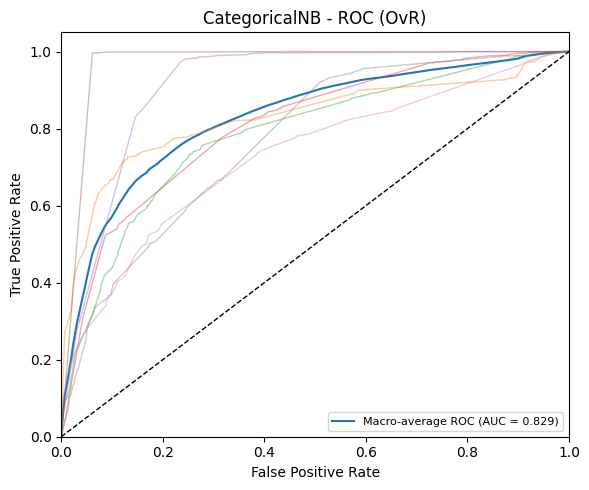

Macro-average AUC (CategoricalNB): 0.8285


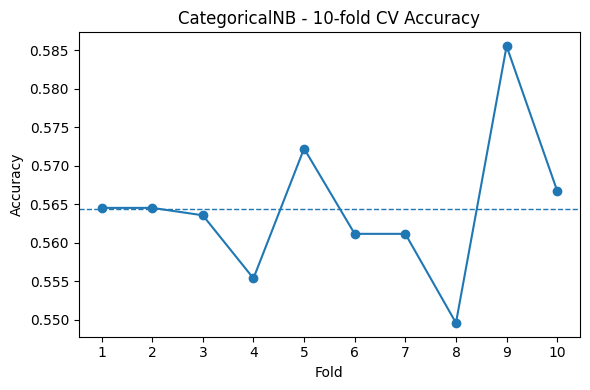

CategoricalNB - 10-fold CV Accuracy: 0.5645 ± 0.0091


In [ ]:
# Cell 10 (renamed vars): CategoricalNB

split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

cat_feature_names = list(categorical_vars.keys())
X_categorical_int = df[cat_feature_names].astype(int).copy()

Xc_train_cat, Xc_test_cat, yc_train_cat, yc_test_cat = train_test_split(
    X_categorical_int, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
)

cnb_model = CategoricalNB()
cnb_model.fit(Xc_train_cat, yc_train_cat)

yc_pred_cat  = cnb_model.predict(Xc_test_cat)
yc_proba_cat = cnb_model.predict_proba(Xc_test_cat)

print("CategoricalNB - Categorical features only")
print(classification_report(yc_test_cat, yc_pred_cat, target_names=class_names))

cm_cat = confusion_matrix(yc_test_cat, yc_pred_cat)
plot_confusion_matrix(cm_cat, class_names, "CategoricalNB - Confusion Matrix")
stats_cat_df = compute_tn_tp_fp_fn(cm_cat, classes=class_names); display(stats_cat_df)

auc_macro_cat = plot_multiclass_roc_auc(yc_test_cat, yc_proba_cat, class_names,
                                        "CategoricalNB - ROC (OvR)")
print(f"Macro-average AUC (CategoricalNB): {auc_macro_cat:.4f}")

cv_cat = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_scores_cat = cross_val_score(cnb_model, X_categorical_int, y, cv=cv_cat, scoring="accuracy")
plot_cv_accuracy(cv_scores_cat, title="CategoricalNB - 10-fold CV Accuracy")

# log
add_result(split_label, "CategoricalNB", yc_test_cat, yc_pred_cat, yc_proba_cat, n_classes)


## 3.XGBoost (thử nghiệm)

In [ ]:
# @title
# # Cell 11 (renamed vars): XGBoost - FE

# split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

# X_train_xgb_fe, X_test_xgb_fe, y_train_xgb_fe, y_test_xgb_fe = train_test_split(
#     X_gaussian_fe, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
# )

# xgb_fe_model = XGBClassifier(
#     objective="multi:softprob", num_class=n_classes,
#     n_estimators=400, learning_rate=0.05, max_depth=5,
#     subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
#     tree_method="hist", eval_metric="mlogloss"
# )
# xgb_fe_model.fit(X_train_xgb_fe, y_train_xgb_fe)

# y_pred_xgb_fe  = xgb_fe_model.predict(X_test_xgb_fe)
# y_proba_xgb_fe = xgb_fe_model.predict_proba(X_test_xgb_fe)

# print("XGBoost - FE only")
# print(classification_report(y_test_xgb_fe, y_pred_xgb_fe, target_names=class_names))

# cm_xgb_fe = confusion_matrix(y_test_xgb_fe, y_pred_xgb_fe)
# plot_confusion_matrix(cm_xgb_fe, class_names, "XGBoost - Confusion Matrix (FE)")
# stats_xgb_fe_df = compute_tn_tp_fp_fn(cm_xgb_fe, classes=class_names); display(stats_xgb_fe_df)

# auc_macro_xgb_fe = plot_multiclass_roc_auc(y_test_xgb_fe, y_proba_xgb_fe, class_names,
#                                            "XGBoost - ROC (FE, OvR)")
# print(f"Macro-average AUC (XGB FE): {auc_macro_xgb_fe:.4f}")

# cv_xgb_fe = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# cv_scores_xgb_fe = cross_val_score(xgb_fe_model, X_gaussian_fe, y, cv=cv_xgb_fe, scoring="accuracy")
# plot_cv_accuracy(cv_scores_xgb_fe, title="XGBoost (FE) - 10-fold CV Accuracy")

# # log
# add_result(split_label, "XGBoost (FE)", y_test_xgb_fe, y_pred_xgb_fe, y_proba_xgb_fe, n_classes)


In [ ]:
# @title
# # Cell 12 (renamed vars): XGBoost - FE + categorical

# split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

# cat_feature_names = list(categorical_vars.keys())
# X_mix_all = pd.concat([X_gaussian_fe, df[cat_feature_names].astype(int)], axis=1)

# num_cols_mix = list(X_gaussian_fe.columns)
# cat_cols_mix = cat_feature_names

# preprocess_mix = ColumnTransformer(
#     [("num", "passthrough", num_cols_mix),
#      ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_mix)]
# )

# xgb_mix_model = XGBClassifier(
#     objective="multi:softprob", num_class=n_classes,
#     n_estimators=400, learning_rate=0.05, max_depth=6,
#     subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
#     tree_method="hist", eval_metric="mlogloss"
# )

# pipe_xgb_mix_model = Pipeline([("preprocess", preprocess_mix),
#                                ("xgb", xgb_mix_model)])

# X_train_xgb_mix, X_test_xgb_mix, y_train_xgb_mix, y_test_xgb_mix = train_test_split(
#     X_mix_all, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
# )

# pipe_xgb_mix_model.fit(X_train_xgb_mix, y_train_xgb_mix)

# y_pred_xgb_mix  = pipe_xgb_mix_model.predict(X_test_xgb_mix)
# y_proba_xgb_mix = pipe_xgb_mix_model.predict_proba(X_test_xgb_mix)

# print("XGBoost - FE + categorical")
# print(classification_report(y_test_xgb_mix, y_pred_xgb_mix, target_names=class_names))

# cm_xgb_mix = confusion_matrix(y_test_xgb_mix, y_pred_xgb_mix)
# plot_confusion_matrix(cm_xgb_mix, class_names, "XGBoost - Confusion Matrix (FE + categorical)")
# stats_xgb_mix_df = compute_tn_tp_fp_fn(cm_xgb_mix, classes=class_names); display(stats_xgb_mix_df)

# auc_macro_xgb_mix = plot_multiclass_roc_auc(y_test_xgb_mix, y_proba_xgb_mix, class_names,
#                                             "XGBoost - ROC (FE + categorical, OvR)")
# print(f"Macro-average AUC (XGB FE+Cat): {auc_macro_xgb_mix:.4f}")

# cv_xgb_mix = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# cv_scores_xgb_mix = cross_val_score(pipe_xgb_mix_model, X_mix_all, y, cv=cv_xgb_mix, scoring="accuracy")
# plot_cv_accuracy(cv_scores_xgb_mix, title="XGBoost (FE + categorical) - 10-fold CV Accuracy")

# # log
# add_result(split_label, "XGBoost (FE+Cat)", y_test_xgb_mix, y_pred_xgb_mix, y_proba_xgb_mix, n_classes)


In [ ]:
# @title
# # Cell 13 (renamed vars): XGBoost + LDA(4) on FE

# split_label = f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"

# X_train_xgb_lda, X_test_xgb_lda, y_train_xgb_lda, y_test_xgb_lda = train_test_split(
#     X_gaussian_fe, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE
# )

# xgb_lda_model = XGBClassifier(
#     objective="multi:softprob", num_class=n_classes,
#     n_estimators=350, learning_rate=0.06, max_depth=4,
#     subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE,
#     tree_method="hist", eval_metric="mlogloss"
# )

# pipe_xgb_lda_model = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lda", LDA(n_components=4)),
#     ("xgb", xgb_lda_model),
# ])

# pipe_xgb_lda_model.fit(X_train_xgb_lda, y_train_xgb_lda)

# y_pred_xgb_lda  = pipe_xgb_lda_model.predict(X_test_xgb_lda)
# y_proba_xgb_lda = pipe_xgb_lda_model.predict_proba(X_test_xgb_lda)

# print("XGBoost + LDA(4) - FE")
# print(classification_report(y_test_xgb_lda, y_pred_xgb_lda, target_names=class_names))

# cm_xgb_lda = confusion_matrix(y_test_xgb_lda, y_pred_xgb_lda)
# plot_confusion_matrix(cm_xgb_lda, class_names, "XGBoost + LDA(4) - Confusion Matrix")
# stats_xgb_lda_df = compute_tn_tp_fp_fn(cm_xgb_lda, classes=class_names); display(stats_xgb_lda_df)

# auc_macro_xgb_lda = plot_multiclass_roc_auc(y_test_xgb_lda, y_proba_xgb_lda, class_names,
#                                             "XGBoost + LDA(4) - ROC (OvR)")
# print(f"Macro-average AUC (XGB + LDA4): {auc_macro_xgb_lda:.4f}")

# cv_xgb_lda = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# cv_scores_xgb_lda = cross_val_score(pipe_xgb_lda_model, X_gaussian_fe, y, cv=cv_xgb_lda, scoring="accuracy")
# plot_cv_accuracy(cv_scores_xgb_lda, title="XGBoost + LDA(4) - 10-fold CV Accuracy")

# # log
# add_result(split_label, "XGBoost + LDA(4)", y_test_xgb_lda, y_pred_xgb_lda, y_proba_xgb_lda, n_classes)


## 4.Tổng hợp kết quả

In [ ]:
# Cell Summary: Build final table (CSV + LaTeX)

method_order = [
    "Dữ liệu gốc",
    "No Weight",
    "FE",
    "PCA 4D (FE)",
    "LDA 4D (FE)",
    "LDA 4D (Original)",
    "CategoricalNB",
    "XGBoost (FE)",
    "XGBoost (FE+Cat)",
    "XGBoost + LDA(4)",
]

split_order = [f"{int(TRAIN_SIZE*100)}/{100-int(TRAIN_SIZE*100)}"]  # nếu bạn chạy nhiều tỉ lệ, thêm vào list này

summary_df, summary_latex = build_results_table(
    split_order=split_order, method_order=method_order,
    latex_path="summary_table.tex", csv_path="summary_table.csv"
)
print(summary_latex)


,Kịch bản,Phương pháp,Accuracy,Precision,Recall,F1-Score,AUC
0,60/40,Dữ liệu gốc,0.6508,0.6318,0.6236,0.6169,0.9173
1,60/40,No Weight,0.5189,0.4645,0.4745,0.4477,0.8022
2,60/40,FE,0.7824,0.7657,0.7652,0.7628,0.9626
3,60/40,PCA 4D (FE),0.5300,0.5020,0.4964,0.4913,0.8693
4,60/40,LDA 4D (FE),0.8112,0.7953,0.7976,0.7942,0.9698
5,60/40,LDA 4D (Original),0.8137,0.7966,0.7980,0.7963,0.9697
6,60/40,CategoricalNB,0.5686,0.5410,0.5279,0.5041,0.8285



LaTeX table saved to: summary_table.tex
CSV saved to: summary_table.csv
\begin{tabular}{llrrrrr}
\toprule
Kịch bản & Phương pháp & Accuracy & Precision & Recall & F1-Score & AUC \\
\midrule
60/40 & Dữ liệu gốc & 0.6508 & 0.6318 & 0.6236 & 0.6169 & 0.9173 \\
60/40 & No Weight & 0.5189 & 0.4645 & 0.4745 & 0.4477 & 0.8022 \\
60/40 & FE & 0.7824 & 0.7657 & 0.7652 & 0.7628 & 0.9626 \\
60/40 & PCA 4D (FE) & 0.5300 & 0.5020 & 0.4964 & 0.4913 & 0.8693 \\
60/40 & LDA 4D (FE) & 0.8112 & 0.7953 & 0.7976 & 0.7942 & 0.9698 \\
60/40 & LDA 4D (Original) & 0.8137 & 0.7966 & 0.7980 & 0.7963 & 0.9697 \\
60/40 & CategoricalNB & 0.5686 & 0.5410 & 0.5279 & 0.5041 & 0.8285 \\
\bottomrule
\end{tabular}



In [ ]:
# Cell Summary (3 scenarios): tổng hợp bảng kết quả cho 80/20, 70/30, 60/40

# Thứ tự hiển thị các kịch bản train/test
split_order = ["80/20", "70/30", "60/40"]

# Thứ tự hiển thị các phương pháp (điền đúng các label bạn đã dùng trong add_result)
method_order = [
    "Dữ liệu gốc",
    "No Weight",
    "FE",
    "PCA 4D (FE)",
    "LDA 4D (FE)",
    "LDA 4D (Original)",
    "CategoricalNB",
    "XGBoost (FE)",
    "XGBoost (FE+Cat)",
    "XGBoost + LDA(4)",
]

# Gọi hàm đã có để tạo bảng, lưu CSV và LaTeX
summary_df, summary_latex = build_results_table(
    split_order=split_order,
    method_order=method_order,
    latex_path="summary_table.tex",
    csv_path="summary_table.csv"
)

# In LaTeX để copy sang báo cáo nếu cần
print(summary_latex)


,Kịch bản,Phương pháp,Accuracy,Precision,Recall,F1-Score,AUC
0,60/40,Dữ liệu gốc,0.6508,0.6318,0.6236,0.6169,0.9173
1,60/40,No Weight,0.5189,0.4645,0.4745,0.4477,0.8022
2,60/40,FE,0.7824,0.7657,0.7652,0.7628,0.9626
3,60/40,PCA 4D (FE),0.5300,0.5020,0.4964,0.4913,0.8693
4,60/40,LDA 4D (FE),0.8112,0.7953,0.7976,0.7942,0.9698
5,60/40,LDA 4D (Original),0.8137,0.7966,0.7980,0.7963,0.9697
6,60/40,CategoricalNB,0.5686,0.5410,0.5279,0.5041,0.8285



LaTeX table saved to: summary_table.tex
CSV saved to: summary_table.csv
\begin{tabular}{llrrrrr}
\toprule
Kịch bản & Phương pháp & Accuracy & Precision & Recall & F1-Score & AUC \\
\midrule
60/40 & Dữ liệu gốc & 0.6508 & 0.6318 & 0.6236 & 0.6169 & 0.9173 \\
60/40 & No Weight & 0.5189 & 0.4645 & 0.4745 & 0.4477 & 0.8022 \\
60/40 & FE & 0.7824 & 0.7657 & 0.7652 & 0.7628 & 0.9626 \\
60/40 & PCA 4D (FE) & 0.5300 & 0.5020 & 0.4964 & 0.4913 & 0.8693 \\
60/40 & LDA 4D (FE) & 0.8112 & 0.7953 & 0.7976 & 0.7942 & 0.9698 \\
60/40 & LDA 4D (Original) & 0.8137 & 0.7966 & 0.7980 & 0.7963 & 0.9697 \\
60/40 & CategoricalNB & 0.5686 & 0.5410 & 0.5279 & 0.5041 & 0.8285 \\
\bottomrule
\end{tabular}

